# Tutorial 2: The usage of cell type-aware module for 10x Visium

To better characterize the spatial similarity at the boundary of spatial domains, STAGATE adopts an attention mechanism to adaptively learn the similarity of neighboring spots, and an optional cell type-aware module through integrating the pre-clustering of gene expressions.

This tutorial demonstrates how to identify spatial domains on 10x Visium data using STAGATE with the cell type-aware module.

In this tutorial, we foucs on the Adult Mouse Brain Section 1 (Coronal) from 10x genomic website (https://www.10xgenomics.com/resources/datasets/adult-mouse-brain-section-1-coronal-stains-dapi-anti-neu-n-1-standard-1-1-0).

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
import STAGATE

In [4]:
adata = sc.read_visium(path='Data', count_file='V1_Adult_Mouse_Brain_Coronal_Section_1_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata

AnnData object with n_obs × n_vars = 2903 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)  
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


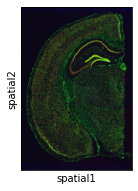

In [7]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires")

## Constructing the spatial network

------Calculating spatial graph...
The graph contains 16982 edges, 2903 cells.
5.8498 neighbors per cell on average.


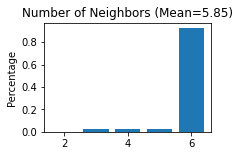

In [8]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=300)
STAGATE.Stats_Spatial_Net(adata)

## Running STAGATE with cell type-aware module

Parameter alpha is the weight of the cell type-aware spatial network, and pre_resolution is the resolution parameter of pre-clustering.

In [9]:
adata = STAGATE.train_STAGATE(adata, alpha=0.5, pre_resolution=0.2, 
                              n_epochs=1000, save_attention=True)

Size of Input:  (2903, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
------Pre-clustering using louvain with resolution=0.20


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

------Pruning the graph...
16982 edges before pruning.
15058 edges after pruning.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.26it/s]


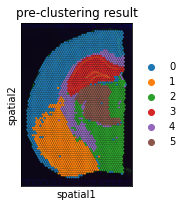

In [10]:
# pre-clustering result
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color="expression_louvain_label", size=1.5, title='pre-clustering result')

In [11]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=1)

In [12]:
adata.uns['louvain_colors']=['#aec7e8', '#9edae5', '#d62728', '#dbdb8d', '#ff9896', 
                             '#8c564b', '#696969', '#778899', '#17becf', '#ffbb78',
                             '#e377c2', '#98df8a', '#aa40fc', '#c5b0d5', '#c49c94',
                             '#f7b6d2', '#279e68', '#b5bd61', '#ad494a', '#8c6d31',
                             '#1f77b4', '#ff7f0e']

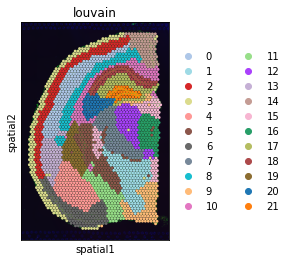

In [13]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(adata, img_key="hires", color="louvain", size=1.5)

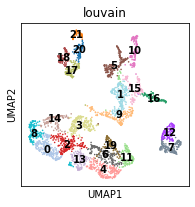

In [14]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color="louvain", legend_loc='on data', s=10)

## Visualization of the attention layer

In [15]:
import matplotlib as mpl
import networkx as nx

In [16]:
att_df = pd.DataFrame(adata.uns['STAGATE_attention'][0].toarray(), index=adata.obs_names, columns=adata.obs_names)
att_df = att_df.values
for it in range(att_df.shape[0]):
    att_df[it, it] = 0

In [17]:
G_atten = nx.from_numpy_matrix(att_df)
M = G_atten.number_of_edges()
edge_colors = range(2, M + 2)

In [18]:
coor_df = pd.DataFrame(adata.obsm['spatial'].copy(), index=adata.obs_names)
coor_df[1] = -1 * coor_df[1]
image_pos = dict(zip(range(coor_df.shape[0]), [np.array(coor_df.iloc[it,]) for it in range(coor_df.shape[0])]))

In [19]:
labels = nx.get_edge_attributes(G_atten,'weight')

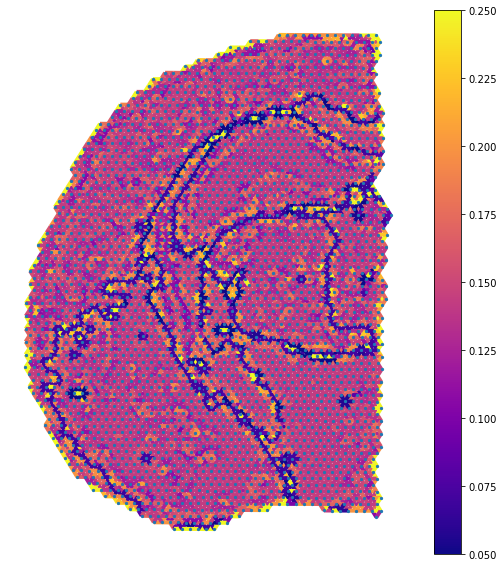

In [20]:
fig, ax = plt.subplots(figsize=[9,10])
nx.draw_networkx_nodes(G_atten, image_pos, node_size=5, ax=ax)
cmap = plt.cm.plasma
edges = nx.draw_networkx_edges(G_atten, image_pos, edge_color=labels.values(),width=4, ax=ax,
                               edge_cmap=cmap,edge_vmax=0.25,edge_vmin=0.05)
ax = plt.gca()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0.05, vmax=0.25))
sm._A = []
plt.colorbar(sm)

ax.set_axis_off()

## Running STAGATE without cell type-aware module (for comparison)

In [21]:
adata = STAGATE.train_STAGATE(adata, alpha=0, n_epochs=1000, save_attention=True)

Size of Input:  (2903, 3000)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.97it/s]


In [22]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=1)

In [23]:
adata.uns['louvain_colors']=['#aec7e8', '#9edae5', '#d62728', '#dbdb8d', '#ff9896', 
                             '#8c564b', '#696969', '#778899', '#17becf', '#ffbb78',
                             '#e377c2', '#98df8a', '#aa40fc', '#c5b0d5', '#c49c94',
                             '#f7b6d2', '#279e68', '#b5bd61', '#ad494a', '#8c6d31',
                             '#1f77b4', '#ff7f0e']

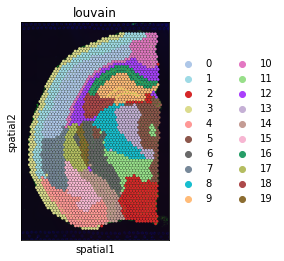

In [24]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(adata, img_key="hires", color="louvain", size=1.5)

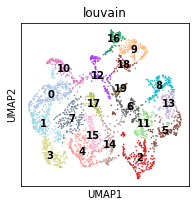

In [25]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color="louvain", legend_loc='on data', s=10)

## Visualization of the attention layer (without cell type-aware module)

In [26]:
att_df = pd.DataFrame(adata.uns['STAGATE_attention'][0].toarray(), index=adata.obs_names, columns=adata.obs_names)
att_df = att_df.values
for it in range(att_df.shape[0]):
    att_df[it, it] = 0

In [27]:
G_atten = nx.from_numpy_matrix(att_df)
M = G_atten.number_of_edges()
edge_colors = range(2, M + 2)

In [28]:
coor_df = pd.DataFrame(adata.obsm['spatial'].copy(), index=adata.obs_names)
coor_df[1] = -1 * coor_df[1]
image_pos = dict(zip(range(coor_df.shape[0]), [np.array(coor_df.iloc[it,]) for it in range(coor_df.shape[0])]))

In [29]:
labels = nx.get_edge_attributes(G_atten,'weight')

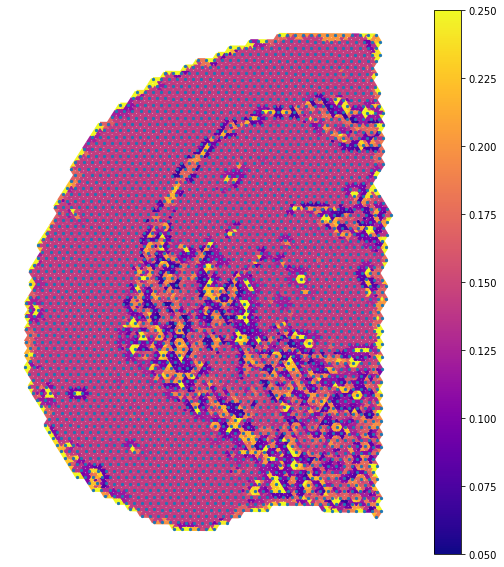

In [30]:
fig, ax = plt.subplots(figsize=[9,10])
nx.draw_networkx_nodes(G_atten, image_pos, node_size=5, ax=ax)
cmap = plt.cm.plasma
edges = nx.draw_networkx_edges(G_atten, image_pos, edge_color=labels.values(),width=4, ax=ax,
                               edge_cmap=cmap,edge_vmax=0.25,edge_vmin=0.05)
ax = plt.gca()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0.05, vmax=0.25))
sm._A = []
plt.colorbar(sm)

ax.set_axis_off()